# Exam project: Dynamical friction
 Dynamical friction inside an elliptical galaxy, generated according to a Hernquist distribution, with a SMBH at the center of it, BH as test particle for the dynamical friction

In [24]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

%matplotlib inline
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['mathtext.fontset']='stix'
matplotlib.rcParams['font.family']='STIXGeneral'

### General Values of the problem 

We make the following choice:

$$ 1 \, r_{iu} = 1\,  kpc = 3 \cdot 10^{21} \,cm $$
$$ 1 \, m_{iu} = 10^{8}\,  M\odot = 2 \cdot 10^{41}\, g $$
$$ 1 \, v_{iu} = 20.55 \, km/s $$

In [25]:
N = 10000 + 1 # number of particle
t = 0 # initial time
M = 100 # total mass of the system 10^10 Msun

a = 2 # Scale parameter, 2 kpc 

mass = M/N # mass of the single particle

M_BH_central = 10 # mass of the central SMBH 10^9 Msun
M_BH_df = 5 # BH where to study the dynamical friction

m = M/N * np.ones(N+1) # adding the central BH
m[0] = 0*m[0] + M_BH_central 
m[1] = 0*m[0] + M_BH_df 


## Generating the Hernquist distribution

Looking to the Hernquist distribution 
$$ \rho ( R) = \frac{M_{tot}}{2\pi}  \frac{a}{ r (r+a)^3}; \quad M(r) = M_{tot}\left(\frac{r}{ r + a}\right)^2;$$ 

Integrating: 
$$ p(r) = \frac{4\pi r^2 \rho(r)}{M_{tot}}  = \frac{2ar}{(r+a)^3}; \quad P(R) = \frac{M(R)}{M_{tot}}=\left(\frac{R}{ R + a}\right)^2.$$


Inverting the relation for $P$: 
$$
\begin{cases}
    R(P) = a \frac{\sqrt{P}}{1-\sqrt{P}} && 0 \le P \le 1 \\ \\
    \varphi = \tilde{\varphi} && 0 \le \tilde{\varphi} \le 2 \pi \\ \\
    \theta = \arccos(1-2 u) &&  0 \le u \le 1 
\end{cases}
$$

#### Sampling on radial coordinate with the inverse transform and velocities with rejection sampling

Hernquist's asrticle: https://ui.adsabs.harvard.edu/abs/1990ApJ...356..359H/abstract

In [26]:
def p_r(q):
    return 2*a*q/((q+a)**3)

def p_θ(q):
    return np.sin(q)/2

def p_ϕ():
    return 1/(2*np.pi)


#-------------

def R_P(P):
    return a * (P**0.5) / (1 - P**0.5)

def r_sample():
    u = np.random.uniform(0,1,N)
    return R_P(u)

def θ_sample():
    u = np.random.uniform(0,1, N)
    return np.arccos(1-2*u)

def ϕ_sample():
    return np.random.uniform(0, 2*np.pi, N)


#-----------------------------------

r = r_sample()
θ = θ_sample()
ϕ = ϕ_sample()
    
    
x = r * np.cos(ϕ) * np.sin(θ)
y = r * np.sin(ϕ) * np.sin(θ)
z = r * np.cos(θ)



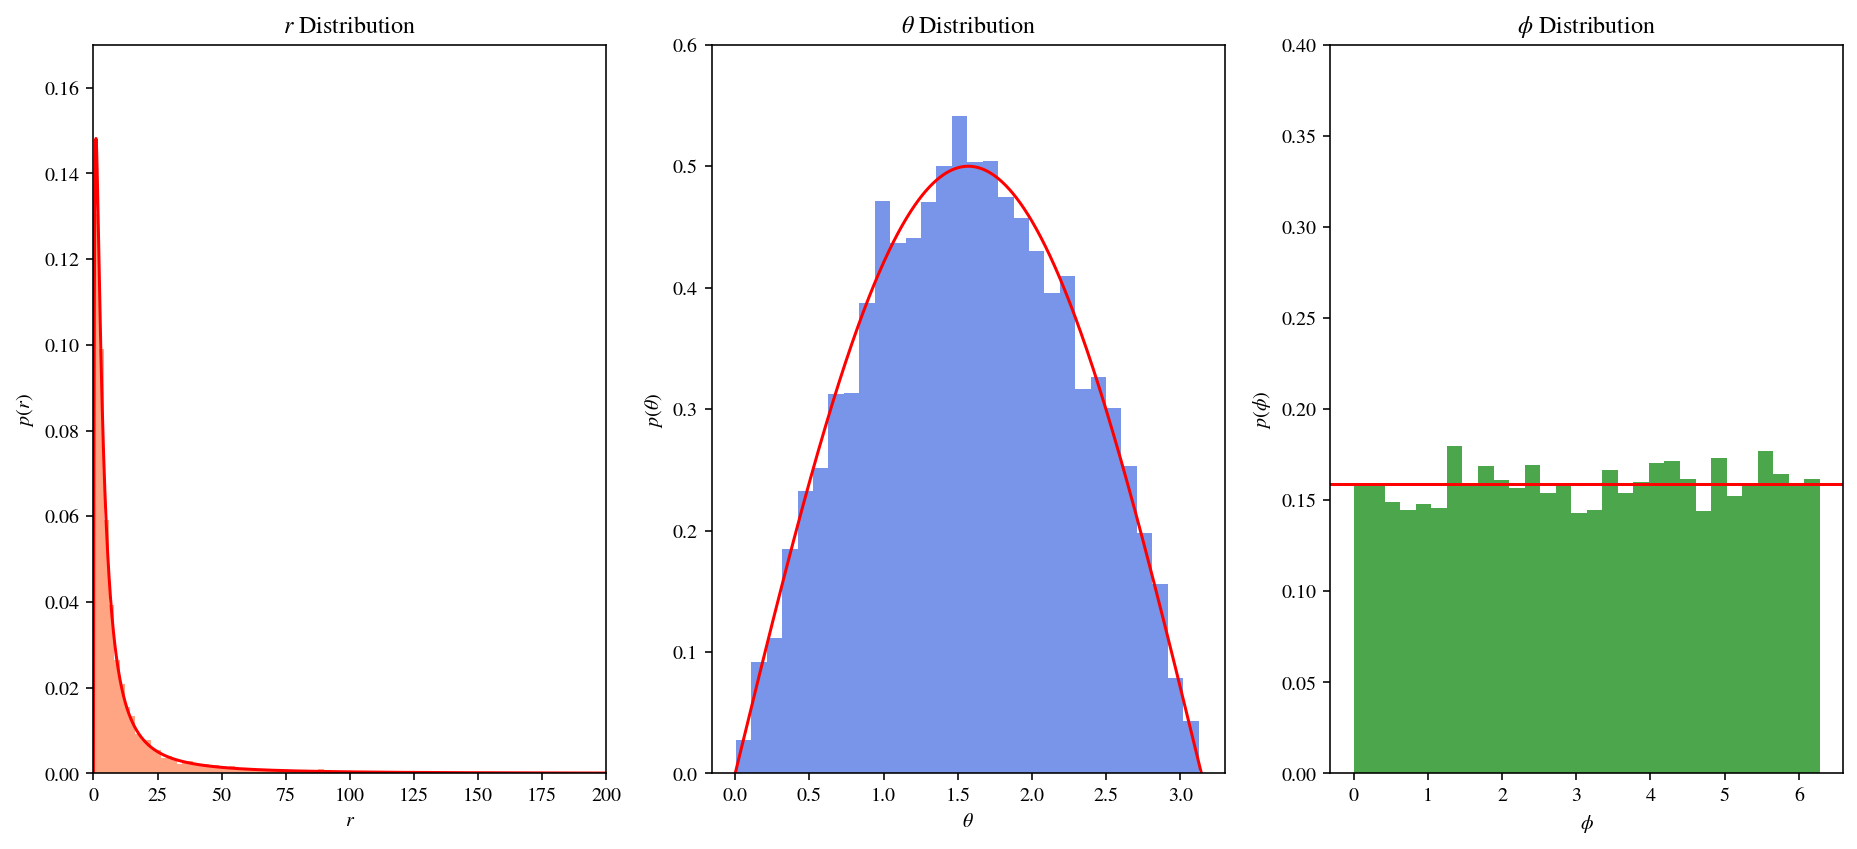

In [63]:
# Plots of the space values distributions

fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(13, 6)) 
q1 = np.linspace(0,200,100000)
bins = np.linspace(0, 100, 50) #for visualisation
ax[0].hist(r, bins = bins, color = 'coral', density=True, alpha=.7, lw=0) 
ax[0].plot(q1, p_r(q1),color='red')
ax[0].set(xlim=(0,200), ylim = (0,0.17), title = fr'$r$ Distribution', xlabel = r'$r$', ylabel=r'$p(r)$') 

q2 = np.linspace(0,np.pi,100000)
ax[1].hist(θ, bins = 30, color = 'royalblue', density=True, alpha=.7, lw=0)
ax[1].plot(q2, p_θ(q2),color='red')
ax[1].set(ylim = (0,0.6), title = fr'$\theta$ Distribution', xlabel = r'$\theta$', ylabel=r'$p(\theta)$')


q3 = np.linspace(0,2+np.pi,100000)

ax[2].hist(ϕ, bins = 30, color = 'green', density=True, alpha=.7, lw=0)
ax[2].axhline(p_ϕ(),color='red')
ax[2].set(ylim = (0,0.4), title = fr'$\phi$ Distribution', xlabel = r'$\phi$', ylabel=r'$p(\phi)$')


plt.show()

In [28]:
# adding the SMBH at the center (0,0,0)

x = np.concatenate(([0], x))
y = np.concatenate(([0], y))
z = np.concatenate(([0], z))


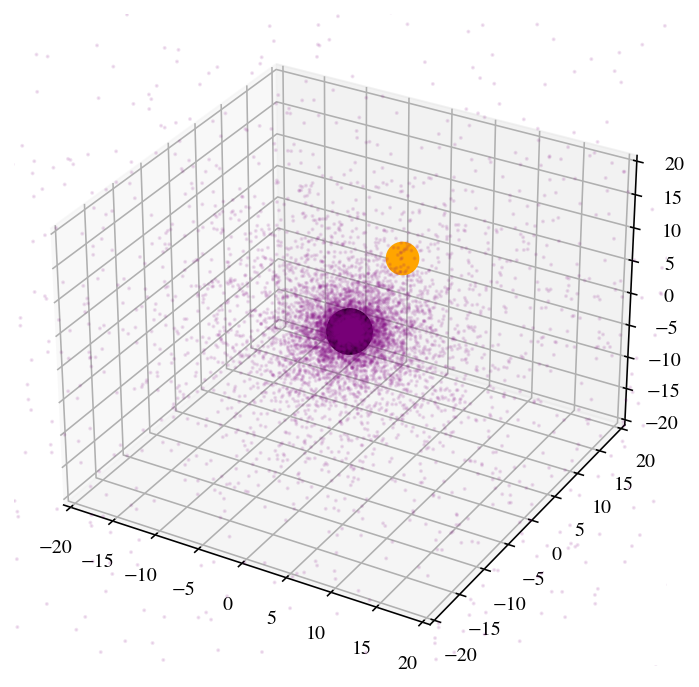

In [30]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(x[0], y[0], z[0], c = 'black', s= 0.5*m[0]/m[2], alpha=1)
ax.scatter(x, y, z, c = 'purple', s=1, alpha=0.1)
ax.scatter(x[1], y[1], z[1], c = 'orange', s= 0.5*m[1]/m[2], alpha=1)
ax.set_aspect('auto')

ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_zlim(-20,20)
plt.show();

In [32]:
print('r and (x,y,z) of the BH_df:', r[0], x[1], y[1], z[1])

r and (x,y,z) of the BH_df: 10.76595249971952 3.1729427913514154 4.914562227990903 9.037989011734476


## Generating velocities

https://arxiv.org/pdf/astro-ph/9309044

### Hernquist distribution
We are working with $ G = 1 $ and $ M_{tot} \neq 0 $ , but for the discusssion below we always write the constant for completness. 

The gravitational potential $ \Phi(r) $ is given by : 

$$ \Phi(r) = - \int_r^\infty \frac{M \Phi(r') \, dr'}{{r'}^2}  = -\frac{G M_{tot}}{a+r} \quad . $$ 

We assume that the phase-space distribution function (DF) depends only on energy, which implies that the velocity-dispersion tensor is isotropic. 

Jeans' theorem ensures that any DF that depends only on energy is a steady-state solution of the collisionless Boltzmann equation. $ f \geq 0 $ is the mass per unit volume of phase space.

Let's define some variables: 
- conserved energy (per unit mass) and relative potential $  E = \Phi + \frac{1}{2} v^2, \quad  \Psi = - \Phi + \Phi_{0} ,$
- relative energy (per unit mass) $ \epsilon \equiv -E + \Phi_{0} = \Psi - \frac{1}{2} v^2 $ .

(these quantities are defned so that we work with non-negative variables).

The density $ \rho $ is given by:

$$ \rho = 2^{5/2} \pi \int_0^{\Psi} f(\epsilon) \, (\psi -\epsilon)^{1/2} \, d\epsilon, $$ 

inverting ad obtaining the Eddington's formula

$$ f(\epsilon) = \frac{1}{2^{3/2} \pi^2} \frac{d}{d\epsilon} \left( \int_0^\epsilon \frac{d\rho}{d\psi} \frac{1}{(\epsilon-\psi)^{1/2}} d\psi \right) = \frac{1}{2^{3/2} \pi^2} \int_0^{\epsilon} \frac{d^2 \rho}{d \psi^2} \frac{1}{(\epsilon-\psi)^{1/2}}d\psi, $$ 

the Hernquist analytic solution is 

$$ f(\epsilon) = \frac{1}{2^{7/2} \pi^3 (\frac{M_{tot}}{a}) (1 - \epsilon)^{5/2}} \left[ 3 \sin^{-1} \left( \sqrt{\epsilon} \right) + \sqrt{\epsilon (1 - \epsilon)} (3 + 2\epsilon - 24\epsilon^2 +16\epsilon^3) \right]. $$



### Hernquist distribution with a central BH 
We modified our system including a BH a the center of it.
$$ \Phi^*(r) \equiv \Phi(r)  - \frac{GM_{BH}}{r},$$

therefore 

$$  f(\epsilon) = \frac{1}{2^{3/2} \pi^2} \frac{d}{d\epsilon} \left( \int_0^\epsilon \frac{d\rho}{d\Psi^*} \frac{1}{(\epsilon-\Psi^*)^{1/2}} d\Psi^* \right). $$ 

Starting from the integral 

$$
J(\epsilon) =  \int_0^\epsilon \frac{d\rho}{d\Psi^*} \frac{1}{(\epsilon-\Psi^*)^{1/2}} d\Psi^*   = \int_0^{u(\epsilon)} \frac{d\rho}{du} \frac{du}{[\epsilon - \Psi^*(u)]^{1/2}} \,,
$$



where we have changed the integration variable to $ u = \frac{1}{r} $ and  $u(\epsilon) $ is defined implicitly by

$$
\Psi^*[u(\epsilon)] = \epsilon.
$$

We have

$$
\Psi^*(u) = - \Phi^*(r) = \frac{u M_{tot}}{1+au} +M_{BH} u \,; \quad \frac{d\rho}{du} = \frac{M_{tot}}{2\pi} \frac{u^3}{ (1+au)^4}[4+au] \,.
$$
 
The cumulative is 

$$ 
F = \int d^3p \, f(\epsilon) = \int_0^{p} 4 \pi p^2 f(p) \, dp
$$



In [33]:
def d_rho_du(u):
    return (M / (2 * np.pi)) * (u**3 / (1 + a*u)**4) * (4 + a*u)

def Psi_star(u):
    return (u*M / (1 + a*u)) + (M_BH_central*u)

# function to find the extreme of integration
def find_u(epsilon):
    # finding the root of the function Psi_star(u) - epsilon, in a region where there should exist at least one root, with the secant method
    root = scipy.optimize.root_scalar(lambda u: Psi_star(u) - epsilon, x0=1e-8, x1=1e-5, method='secant')
    return root.root if root.converged else None

def J(epsilon):
    u_eps = find_u(epsilon)
    if u_eps is None:
        return 0
    
    result, _ = scipy.integrate.quad(lambda u: d_rho_du(u) / np.sqrt(epsilon - Psi_star(u)), 0, u_eps)
    return result

def f_single(epsilon):
    J_val = J(epsilon)
    epsilon_delta = 1e-5
    J_val_plus = J(epsilon + epsilon_delta)
    df_depsilon = (J_val_plus - J_val) / epsilon_delta
    return (1 / (2**(3/2) * np.pi**2)) * df_depsilon

def F(epsilon):
    p_max = mass * np.sqrt(2 * epsilon)
    integral, _ = scipy.integrate.quad(lambda p: 4 * np.pi * p**2 * f_single(p**2 / (2 * mass)), 0, p_max)
    return integral


In [64]:
epsilon_values = np.linspace(0.01, 0.999, N)  # Not taking 1 in order to avoid divergency
F_values = np.array([F(eps) for eps in tqdm(epsilon_values, desc="Calcolo F_values")])
F_values /= np.sum(F_values) # Normalization

Calcolo F_values: 100%|██████████████████████████████████████████████████████████| 10001/10001 [02:41<00:00, 61.93it/s]


In [68]:
u_samples = np.random.uniform(0, 1, N)  

ϵ_sampled = np.interp(u_samples, F_values, epsilon_values)
θ_2 = θ_sample()
ϕ_2 = ϕ_sample()


v_arg = 2 * (M / (a + r)**2 + M_BH_central/r - ϵ_sampled)

# Check for negatives values
if np.any(v_arg < 0):
    num_negativi = np.sum(v_arg < 0)
    print(f"Valori negativi trovati: {num_negativi}")

v = np.sqrt(np.clip(v_arg, 0, None)) 



v_x = v * np.sin(θ_2) * np.cos(ϕ_2)
v_y = v * np.sin(θ_2) * np.sin(ϕ_2) 
v_z = v * np.cos(θ_2)

Valori negativi trovati: 2206


In [69]:
# adding the SMBH with v=(0,0,0)

v_x = np.concatenate(([0], v_x))
v_y = np.concatenate(([0], v_y))
v_z = np.concatenate(([0], v_z))


In [70]:
print('(vx,vy,vz) of the BH_df:', v_x[1], v_y[1], v_z[1])

(vx,vy,vz) of the BH_df: 0.12369215899027576 1.0351396947645464 0.010844308282409157


## Input file

In [71]:
dim = 3

with open ('in_data.txt', 'w+') as f:
    f.write(str(N+1) + '\n')
    f.write(f'{dim}' + '\n')
    f.write('0' + '\n')
    for m_i in m:
        f.write(f'{m_i}' + '\n')
    for i in range(N):
        f.write(f'{x[i]} {y[i]} {z[i]}' + '\n')
    for j in range(N):
        f.write(f'{v_x[j]} {v_y[j]} {v_z[j]}' + '\n')